集成学习(Ensemble learning)通过构建并结合多个学习器来完成学习任务，有时也被称为多分类器系统。集成学习的一般结构为：先产生一组“个体学习器”，再用某种策略将它们结合起来。集成中只包含同种类型的个体学习器，称为同质，当中的个体学习器亦称为“基学习器”，相应的算法称为“基学习算法”。集成中包含不同类型的个体学习器，称为“异质”，当中的个体学习器称为“组建学习器”。

In [8]:
import numpy as np
class DecisionTreeClassifierWithWeight:
    def __init__(self):
         self.best_err = 1  # 最小的加权错误率 
         self.best_fea_id = 0  # 最优特征id
         self.best_thres = 0  # 选定特征的最优阈值
         self.best_op = 1  # 阈值符号，其中 1: >, 0: < 
    def fit(self, X, y, sample_weight=None):
         if sample_weight is None:
             sample_weight = np.ones(len(X)) / len(X)
         n = X.shape[1]
         for i in range(n):
             feature = X[:, i]  # 选定特征列
             fea_unique = np.sort(np.unique(feature))  # 将所有特征值从小到大排序
             for j in range(len(fea_unique)-1):
                 thres = (fea_unique[j] + fea_unique[j+1]) / 2  # 逐一设定可能阈值
                 for op in (0, 1):
                     y_ = 2*(feature >= thres)-1 if op==1 else 2*(feature < thres)-1  # 判断何种符号为最优
                     err = np.sum((y_ != y)*sample_weight)
                     if err < self.best_err:  # 当前参数组合可以获得更低错误率，更新最优参数
                         self.best_err = err
                         self.best_op = op
                         self.best_fea_id = i
                         self.best_thres = thres
         return self
    def predict(self, X):
        feature = X[:, self.best_fea_id]
        return 2*(feature >= self.best_thres)-1 if self.best_op==1 else 2*(feature < self.best_thres)-1
    def score(self, X, y, sample_weight=None):
        y_pre = self.predict(X)
        if sample_weight is not None:
            return np.sum((y_pre == y)*sample_weight) 
        return np.mean(y_pre == y)

In [52]:
class AdaBoostClassifier:
    def __init__(self, n_estimators=50):
         self.n_estimators = n_estimators 
         self.estimators = []
         self.alphas = []
    def fit(self, X, y):
         sample_weight = np.ones(len(X)) / len(X)  # 初始化样本权重为 1/N
         for _ in range(self.n_estimators):
             dtc = DecisionTreeClassifierWithWeight().fit(X, y, sample_weight)  # 训练弱学习器
             alpha = 1/2 * np.log((1-dtc.best_err)/dtc.best_err)  # 权重系数
             y_pred = dtc.predict(X)
             sample_weight *= np.exp(-alpha*y_pred*y)  # 更新迭代样本权重
             sample_weight /= np.sum(sample_weight)  # 样本权重归一化
             self.estimators.append(dtc)
             self.alphas.append(alpha)
         return self   

    def predict(self, X):
         y_pred = np.empty((len(X), self.n_estimators))  # 预测结果二维数组，其中每一列代表一个弱学习器的预测结果
         for i in range(self.n_estimators):
             y_pred[:, i] = self.estimators[i].predict(X)
         y_pred = y_pred * np.array(self.alphas)  # 将预测结果与训练权重乘积作为集成预测结果
         return 2*(np.sum(y_pred, axis=1)>0)-1  # 以0为阈值，判断并映射为-1和1
    def score(self, X, y):
         y_pred = self.predict(X)
         return np.mean(y_pred==y)
#使用sklearn自带的乳腺癌数据集测试：
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
X, y = load_breast_cancer(return_X_y=True)
y = 2*y-1  # 将0/1取值映射为-1/1取值 
x_train, x_test, y_train, y_test = train_test_split(X, y,random_state=42)
print(AdaBoostClassifier().fit(x_train, y_train).score(x_test, y_test)) 

0.972027972027972


对于随机森林回归器（RandomForestRegressor），score 方法默认使用 R² 分数来评估模型的性能，而不是准确率。这是因为随机森林回归器主要用于回归任务，而不是分类任务。它的 score 方法如下所示：

   Size  Bedrooms  Location  Price
0   100         2         0      0
1   120         3         1      1
2    90         2         0      0
3   110         2         0      1
4   150         3         1      2
MSE: 0.7548333333333334
R-squared: 0.15081250000000013
0.0


Text(0.5, 1.0, '随机森林回归特征重要性')

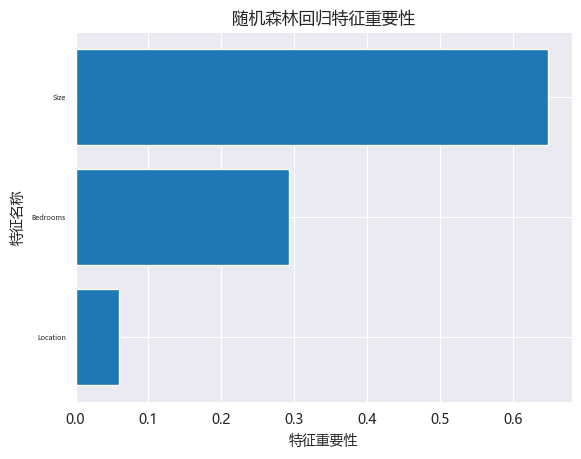

In [51]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
data = {
    'Size': [100, 120, 90, 110, 150, 160, 140, 130, 180, 200],
    'Bedrooms': [2, 3, 2, 2, 3, 4, 3, 3, 4, 5],
    'Location': ['Suburban', 'City Center', 'Suburban', 'Suburban', 'City Center', 'City Center', 'Suburban', 'City Center', 'Suburban', 'City Center'],
    'Price': ['Low', 'Medium', 'Low', 'Medium', 'High', 'High', 'Medium', 'High', 'High', 'Very High']
}
replacement1 = {'Suburban':0,"City Center":1}
replacement2 = {'Low':0,"Medium":1,"High":2,"Very High":3}

data1 = pd.DataFrame(data)
data1['Location'] = data1['Location'].map(replacement1)
data1['Price'] = data1['Price'].map(replacement2)
print(data1.head())
x = data1.iloc[:,0:-1]
y = data1.iloc[:,-1]
x_train ,x_test ,y_train ,y_test = train_test_split(x , y ,test_size = 0.3)
rf = RandomForestRegressor(n_estimators=100, random_state=42) #n_estimator 表示随机树的数量
rf.fit(x_train, y_train)
y_predict = rf.predict(x_test)

mse = mean_squared_error(y_test, y_predict)  #均方误差 它的值越小表示模型的预测效果越好  如果预测完全正确，MSE 的值为 0
r2 = r2_score(y_test, y_predict)             #决定系数 R² 越接近于 1，表示模型拟合得越好；如果 R² 接近于 0 或者是负数，则表示模型的预测效果不佳
# 输出模型评估结果和目标方程
print('MSE:', mse)
print('R-squared:', r2)

feature_importance = rf.feature_importances_
feature_names = x.columns.tolist()
sorted_idx = feature_importance.argsort() #排序
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.barh(range(len(feature_importance)), feature_importance[sorted_idx])
plt.yticks(range(len(feature_importance)), [feature_names[i] for i in sorted_idx],fontsize=5)
plt.xlabel('特征重要性')
plt.ylabel('特征名称')
plt.title('随机森林回归特征重要性')

In [46]:
from sklearn.ensemble import RandomForestClassifier

# 创建随机森林分类器
rf = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',  # 默认为 'sqrt'，表示取特征数量的平方根
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=42,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None
)

# 训练随机森林分类器
rf.fit(X_train, y_train)

# 预测并评估
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy: {:.2f}%".format(accuracy * 100))

Random Forest Accuracy: 88.00%


In [47]:
#自定义bagging
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class CustomBaggingClassifier:
    def __init__(self, n_estimators=100, max_samples=0.5, max_features=0.5, random_state=None):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_features = max_features
        self.random_state = random_state
        self.estimators_ = []

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        
        n_samples, n_features = X.shape
        for _ in range(self.n_estimators):
            # 有放回地抽样
            indices = rng.choice(n_samples, size=int(self.max_samples * n_samples), replace=True)
            features_indices = rng.choice(n_features, size=int(self.max_features * n_features), replace=True)
            
            X_bootstrap, y_bootstrap = X[indices][:, features_indices], y[indices]
            
            tree = DecisionTreeClassifier()
            tree.fit(X_bootstrap, y_bootstrap)
            self.estimators_.append((tree, features_indices))

    def predict(self, X):
        predictions = np.array([estimator.predict(X[:, features]) for estimator, features in self.estimators_])
        return np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=predictions)

# 创建数据集
X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=10, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 自定义 Bagging 分类器
custom_bagging = CustomBaggingClassifier(n_estimators=100, max_samples=0.5, max_features=0.5, random_state=42)
custom_bagging.fit(X_train, y_train)

# 预测并评估
y_pred = custom_bagging.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Custom Bagging Accuracy: {:.2f}%".format(accuracy * 100))

Custom Bagging Accuracy: 87.60%
